# <span id="2"></span> Importing Modules, Reading the Dataset and Defining an Evaluation Table
<hr/>

In order to make some analysis, we need to set our environment up. To do this, I firstly imported some modules and read data. The below output is the head of the data but if you want to see more details, you might try removing ***#*** signs in front of the ***df.describe()*** and ***df.info()***.  

Further, I defined an empty dataframe. This dataframe includes **Root Mean Squared Error (RMSE), R-squared, Adjusted R-squared** and **mean of the R-squared values obtained by the k-Fold Cross Validation**, which are the important metrics to compare different models. Having a **R-squared value closer to one** and **smaller RMSE** means a better fit. In the following sections, I will fill this dataframe with my results.

In [ ]:
# !pip install folium

In [2]:
import numpy as np
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn import metrics
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import folium
from folium.plugins import HeatMap
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import ShuffleSplit

In [3]:
result_path = "C:\\Users\\DKici\\Documents\\PricingPromo\\Results\\Marketing_Spend_and_Sales\\"

The following dataframe includes Root Mean Squared Error (RMSE), R-squared, Adjusted R-squared and mean of the R-squared values obtained by the k-Fold Cross Validation, which are the important metrics to compare different models. Having a R-squared value closer to one and smaller RMSE means a better fit.

Read the dataset

In [4]:
# my_df = pd.read_csv('C:\\Users\\DKici\\Documents\\PricingPromo\\data\\Marketing_Spend_Data\\Marketing_Spend_and_Sales_Weekly.csv')
# my_df = my_df.drop(columns =["Unnamed: 0"], axis = 1)

# my_df = pd.read_csv('C:\\Users\\DKici\\Documents\\PricingPromo\\data\\Marketing_Spend_Data\\Marketing_Spend_and_Sales_Weekly_with_GrossSales.csv')
my_df = pd.read_csv('/content/Marketing_Spend_Weekly_with_GrossSales.csv')

my_df = my_df.drop(columns =["Unnamed: 0"], axis = 1)

my_df.describe()
my_df.info()
my_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106 entries, 0 to 105
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Weekly_Date         106 non-null    object 
 1   undefined_funnel    106 non-null    float64
 2   BOFU                106 non-null    float64
 3   MOFU                74 non-null     float64
 4   TOFU                106 non-null    float64
 5   undefined_category  106 non-null    float64
 6   Accessories         73 non-null     float64
 7   Appliance           50 non-null     float64
 8   Bedroom             106 non-null    float64
 9   Dining Room         106 non-null    float64
 10  Finance             11 non-null     float64
 11  Furniture           8 non-null      float64
 12  Living Room         106 non-null    float64
 13  Mattress            106 non-null    float64
 14  Office              106 non-null    float64
 15  Outdoor             22 non-null     float64
 16  WrittenS

,Weekly_Date,undefined_funnel,BOFU,MOFU,TOFU,undefined_category,Accessories,Appliance,Bedroom,Dining Room,Finance,Furniture,Living Room,Mattress,Office,Outdoor,WrittenSales,GrossWrittenSales,Traffic,Margin
0,2019-12-30,16935.0,18495.0,NaN,3518.0,30315.0,NaN,NaN,6849.0,453.0,NaN,NaN,742.0,368.0,220.0,NaN,2392138.46,2562146.07,13859.0,1063626.90
1,2020-01-06,19842.0,14446.0,NaN,4645.0,32552.0,NaN,NaN,4120.0,568.0,NaN,NaN,1072.0,418.0,203.0,NaN,2043289.53,2319326.72,12410.0,983523.10
2,2020-01-13,24642.0,53766.0,NaN,4786.0,81296.0,NaN,NaN,387.0,379.0,NaN,NaN,719.0,317.0,97.0,NaN,2273277.34,2751651.73,11158.0,1075415.48
3,2020-01-20,23311.0,48472.0,NaN,4661.0,73583.0,NaN,NaN,576.0,531.0,NaN,NaN,1178.0,361.0,214.0,NaN,1972721.88,2439144.33,13581.5,1023192.21
4,2020-01-27,35561.0,32694.0,NaN,4624.0,66823.0,48.0,NaN,1522.0,1313.0,NaN,NaN,2063.0,646.0,463.0,NaN,3191924.25,3473314.76,14282.0,1452702.25


TOFU  “Top of Funnel”: These ads initiate an interaction with a potential customer, as opposed to continuing an ongoing interaction. These might include 
-	tv/radio ads 
-	website banner ads 
-	posts on social media 
-	billboards 
-	etc.

MOFU “Middle of Funnel”: These are ads targeted to those we have interacted with before. They might include:
-	Emails to potential customers who filled out a survey, clicked on a banner ad, previously called/visited the store etc.
-	Ads that show up in the potential customer’s social media feed due to some previously expressed interest.
-	Mailed coupons/deal offers due to a customer’s purchase history with us.
-	Etc.

BOFU “Bottom of Funnel”: These are ads that lead directly to a purchase, usually after interacting with the rest of the “funnel”
-	We need to understand the practical difference between this and MOFU.


In [5]:
my_df.columns

Index(['Weekly_Date', 'undefined_funnel', 'BOFU', 'MOFU', 'TOFU',
       'undefined_category', 'Accessories', 'Appliance', 'Bedroom',
       'Dining Room', 'Finance', 'Furniture', 'Living Room', 'Mattress',
       'Office', 'Outdoor', 'WrittenSales', 'GrossWrittenSales', 'Traffic',
       'Margin'],
      dtype='object')

In [6]:
my_df = my_df[['Weekly_Date', 'undefined_funnel', 'BOFU', 'MOFU', 'TOFU', 'WrittenSales', 'GrossWrittenSales', 'Traffic',
       'Margin']]

In [7]:
my_df.set_index("Weekly_Date", inplace=True)
my_df.head(2)

,undefined_funnel,BOFU,MOFU,TOFU,WrittenSales,GrossWrittenSales,Traffic,Margin
Weekly_Date,,,,,,,,
2019-12-30,16935.0,18495.0,NaN,3518.0,2392138.46,2562146.07,13859.0,1063626.9
2020-01-06,19842.0,14446.0,NaN,4645.0,2043289.53,2319326.72,12410.0,983523.1


# <span id="3"></span> Defining a Function to Calculate the Adjusted $R^{2}$
<hr/>

The R-squared increases when the number of features increase. Because of this, sometimes a more robust evaluator is preferred to compare the performance between different models. This evaluater is called adjusted R-squared and it only increases, if the addition of the variable reduces the MSE. The definition of the adjusted $R^{2}$ is:

$\bar{R^{2}}=R^{2}-\frac{k-1}{n-k}(1-R^{2})$

where $n$ is the number of observations and $k$ is the number of parameters. 

In [8]:
def adjustedR2(r2,n,k):
    return r2-(k-1)/(n-k)*(1-r2)

# <span id="6"></span> Visualizing and Examining Data
<hr/>

This is not a very big data and we do not have too many features. Thus, we have chance to plot most of them and reach some useful analytical results. Drawing charts and examining the data before applying a model is a very good practice because we may detect some possible outliers or decide to do normalization. This is not a must but get know the data is always good. Then, I started with the histograms of dataframe.

In [9]:
my_df.shape

(106, 8)

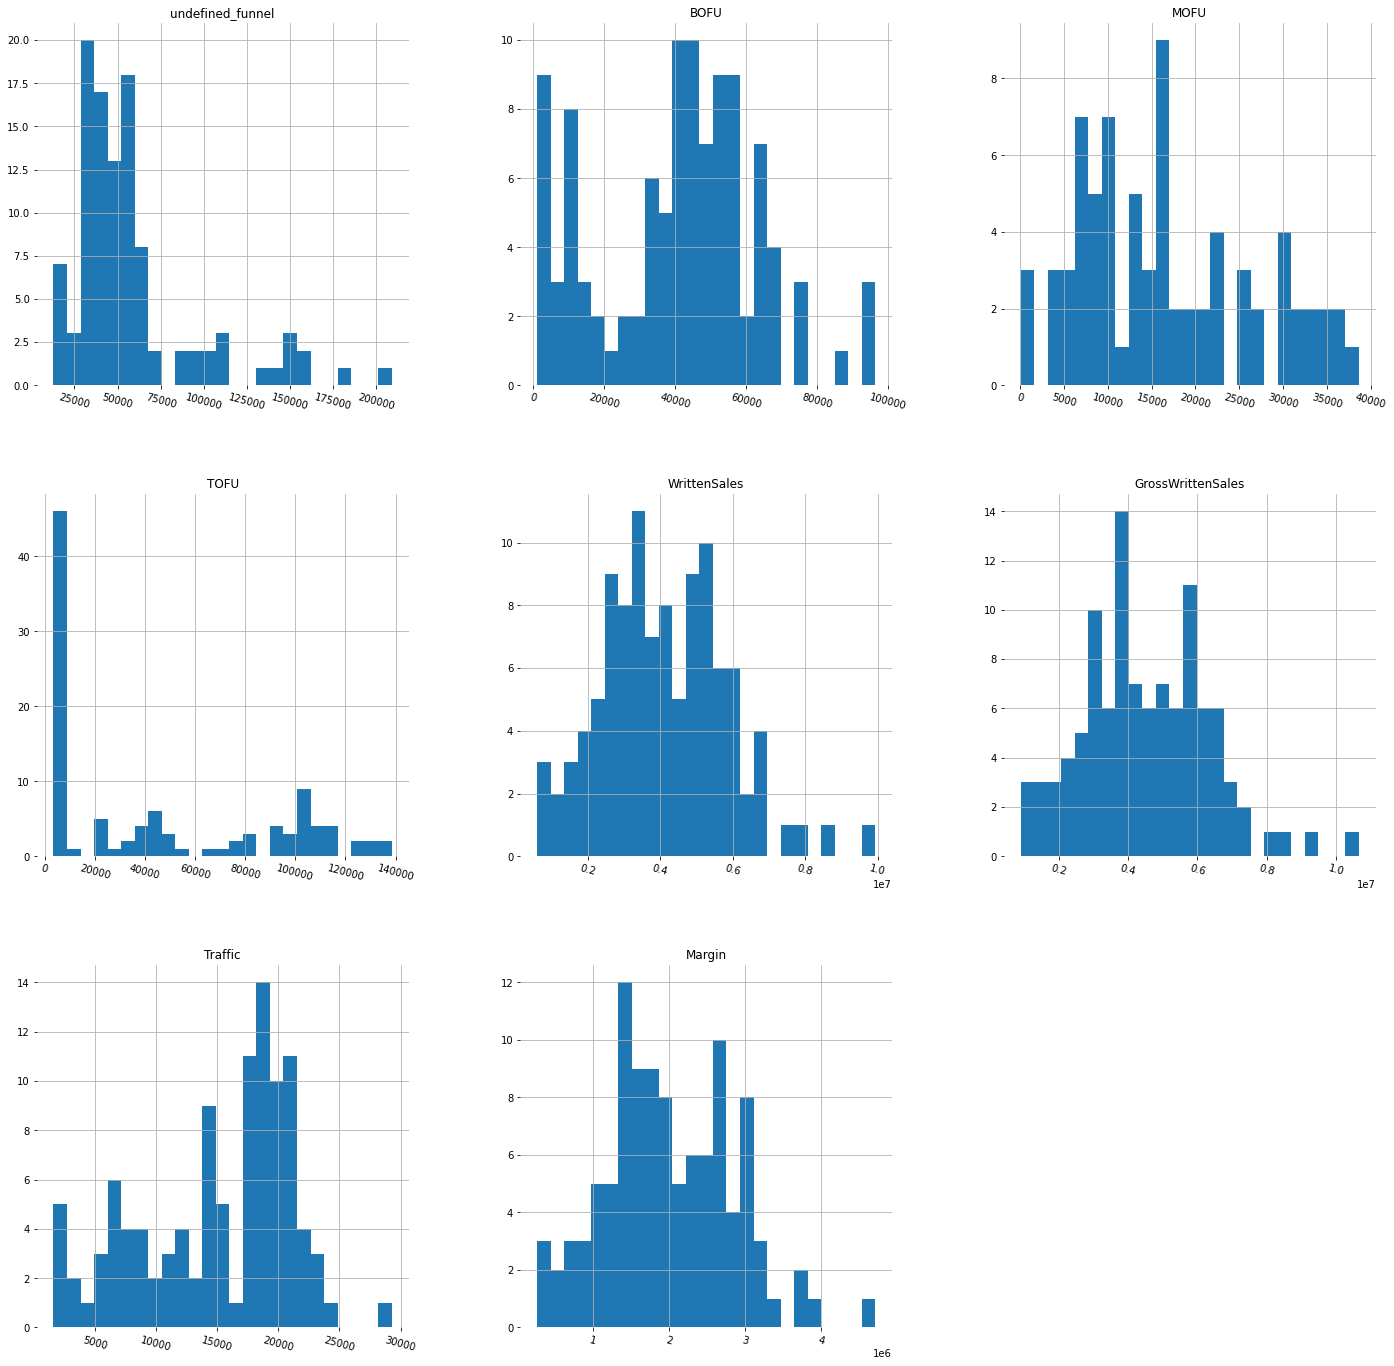

In [10]:
h = my_df.hist(bins=25,figsize=(24,24),xlabelsize='10',ylabelsize='10',xrot=-15)
sns.despine(left=True, bottom=True)
[x.title.set_size(12) for x in h.ravel()];
[x.yaxis.tick_left() for x in h.ravel()];

# plt.savefig(f'{result_path}\\Marketing_Spend_Funnel_Position_distribution.jpeg')

In [11]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
my_df_scaled = sc.fit_transform(my_df)

To determine bedrooms, floors or bathrooms/bedrooms vs price, I preferred **boxplot** because we have numerical data but they are not continuous as 1,2,... bedrooms, 2.5, 3,... floors (probably 0.5 stands for the penthouse). 

From the below charts, it can be seen that there are very few houses which have some features or price appears far from others like 33 bedrooms or price around 7000000. However, determining their possible negative effect will be time consuming and in the real data sets there will always be some outliers like some luxury house prices in this dataset. That's why I am not planning to remove outliers.

In [12]:
sns.set(style="whitegrid", font_scale=1)

To determine Percent Amount, nth day of week, nth day of  month,  month of the year, Store Open or Percent Amount/ nth day of the month vs WrittenSales, I preferred boxplot because we have numerical data but they are not continuous as 1,2,... bedrooms, 2.5, 3,... floors.

From the below charts, it can be seen that there are very few instances which have some features or sales appears far from others like Sunday  or sales around 350000.

In [13]:
my_df.columns

Index(['undefined_funnel', 'BOFU', 'MOFU', 'TOFU', 'WrittenSales',
       'GrossWrittenSales', 'Traffic', 'Margin'],
      dtype='object')

In [ ]:
# f, axes = plt.subplots(1, 2,figsize=(15,5))
# sns.boxplot(x=my_df['BOFU'],y=my_df['WrittenSales'], ax=axes[0])
# sns.boxplot(x=my_df['MOFU'],y=my_df['WrittenSales'], ax=axes[1])

# sns.despine(left=True, bottom=True)
# axes[0].set(xlabel='BOFU', ylabel='WrittenSales')
# axes[0].yaxis.tick_left()
# axes[1].yaxis.set_label_position("right")
# axes[1].yaxis.tick_right()
# axes[1].set(xlabel='MOFU', ylabel='WrittenSales')

# f, axes = plt.subplots(1, 2,figsize=(15,5))
# sns.boxplot(x=my_df['TOFU'],y=my_df['WrittenSales'], ax=axes[0])
# sns.boxplot(x=my_df['Accessories'],y=my_df['WrittenSales'], ax=axes[1]) 
# sns.despine(left=True, bottom=True)
# axes[0].set(xlabel='TOFU', ylabel='WrittenSales')
# axes[0].yaxis.tick_lefts()
# axes[1].yaxis.set_label_position("right")
# axes[1].yaxis.tick_right()
# axes[1].set(xlabel='Accessories', ylabel='WrittenSales')

In [ ]:
# f, axe = plt.subplots(1, 1,figsize=(12.18,5))
# sns.despine(left=True, bottom=True)
# sns.boxplot(x=my_df[' Percent  Amount'],y=my_df['WrittenSales'], ax=axe)
# axe.yaxis.tick_left()
# axe.set(xlabel=' Percent  Amount / nth_day_of_month', ylabel='WrittenSales');

I drew the price vs some features and it seems that there is not a perfect linear relationship between the price and these features. On the other hand, what about the relationship among each other? To show this, I preferred 3D plots. Also, I used light green as the  point color. Dark green parts mean high density, many light green points overlap and become darker. 

The below charts show that when the sqrt_living increases, sqrt_lot and bedrooms or bathrooms/bedrooms increases. However, the floors, bedrooms and bathrooms/bedrooms or sqrt_living does not have a similar relationship.  

In [ ]:
# fig=plt.figure(figsize=(19,12.5))
# ax=fig.add_subplot(2,2,1, projection="3d")
# ax.scatter(my_df.iloc[:,6],my_df.iloc[:,7],my_df.iloc[:,8],c="darkgreen",alpha=.5)
# ax.set(xlabel='\nWrittenSales',ylabel='\nMargin',zlabel='\nTraffic')
# ax.set(ylim=[0,12])

# ax=fig.add_subplot(2,2,2, projection="3d")
# ax.scatter(df['StoreOpen'],df[' Percent  Amount'],df['month_of_the_year'],c="darkgreen",alpha=.5)
# ax.set(xlabel='\nStore Open',ylabel='\n Percent  Amount',zlabel='\nmonth_of_the_year')
# ax.set(ylim=[0,12])

# ax=fig.add_subplot(2,2,3, projection="3d")
# ax.scatter(df['sqft_living'],df['sqft_lot'],df['bathrooms'],c="darkgreen",alpha=.5)
# ax.set(xlabel='\n sqft Living',ylabel='\nsqft Lot',zlabel='\nBathrooms / Bedrooms')
# ax.set(ylim=[0,250000])

# ax=fig.add_subplot(2,2,4, projection="3d")
# ax.scatter(df['sqft_living'],df['sqft_lot'],df['bedrooms'],c="darkgreen",alpha=.5)
# ax.set(xlabel='\n sqft Living',ylabel='\nsqft Lot',zlabel='Bedrooms')
# ax.set(ylim=[0,250000]);

Let's visualize more features. When we look at the below boxplots, grade and waterfront effect price visibly. On the other hand, view seem to effect less but it also has an effect on price. 

Further, I drew the 3D plot to determine the relation between the view, grade and year built. The below chart shows that the newer houses have better grades but we can not say much about the change in the view.  

## <span id="7"></span> Checking Out the Correlation Among Explanatory Variables

Having too many features in a model is not always a good thing because it might cause overfitting and worser results when we want to predict values for a new dataset. Thus, **if a feature does not improve your model a lot, not adding it may be a better choice**.

Another important thing is correlation. **If there is very high correlation between two features, keeping both of them is not a good idea most of the time not to cause overfitting**. For instance, if there is overfitting, we may remove sqt_above or sqt_living because they are highly correlated. This relation can be estimated when we look at the definitions in the dataset but to be sure correlation matrix should be checked. However, this does not mean that you must remove one of the highly correlated features. For example: bathrooms and sqrt_living. They are highly correlated but I do not think that the relation among them is the same as the relation between sqt_living and sqt_above.

In [ ]:
my_mask = np.zeros_like(my_df.corr(), dtype=np.bool) 
my_mask[np.triu_indices_from(my_mask)] = True 

f, ax = plt.subplots(figsize=(40, 36))
plt.title('Pearson Correlation Matrix',fontsize=25)

sns.set(style="white", font_scale=2)

# sns.heatmap(my_df.corr(),linewidths=0.25,vmax=0.7,square=True,cmap="BuGn", #"BuGn_r" to reverse 
#             linecolor='w',annot=True,annot_kws={"size":8},mask=my_mask,cbar_kws={"shrink": .9});

sns.heatmap(my_df.corr(),annot=True,annot_kws={"size":24});

# plt.savefig(f'{result_path}\\Marketing_Spend_Data_correlation.jpeg')

In [ ]:
my_df.corr()

,undefined_funnel,BOFU,MOFU,TOFU,WrittenSales,GrossWrittenSales,Traffic,Margin
undefined_funnel,1.000000,0.380984,0.556058,0.436177,0.640513,0.659049,0.566860,0.648606
BOFU,0.380984,1.000000,0.230530,0.441419,0.613747,0.617384,0.468027,0.614990
MOFU,0.556058,0.230530,1.000000,0.358381,0.431988,0.440696,0.380303,0.500082
TOFU,0.436177,0.441419,0.358381,1.000000,0.550236,0.559255,0.392527,0.567536
WrittenSales,0.640513,0.613747,0.431988,0.550236,1.000000,0.998446,0.834311,0.995076
GrossWrittenSales,0.659049,0.617384,0.440696,0.559255,0.998446,1.000000,0.843866,0.994690
Traffic,0.566860,0.468027,0.380303,0.392527,0.834311,0.843866,1.000000,0.838928
Margin,0.648606,0.614990,0.500082,0.567536,0.995076,0.994690,0.838928,1.000000


In [ ]:
corr = my_df.corr(method='pearson').iloc[:,-3]
corr_df = pd.DataFrame(data = corr, index = corr.index ).sort_values (by = 'GrossWrittenSales', ascending = False)

sns.set(style="white", font_scale=3.5)
plt.figure(figsize = (20,20))
sns.set_palette('mako')
plt.xticks(rotation = 90)
plt.title('Feature correlation with Gross Written Sales')
sns.barplot (data = corr_df, x = corr_df.index, y = 'GrossWrittenSales');

# plt.savefig(f'{result_path}\\Marketing_Spend_Data_correlation_GrossWrittenSales.jpeg')

In [ ]:
corr = my_df.corr(method='pearson').iloc[:,-4]
corr_df = pd.DataFrame(data = corr, index = corr.index ).sort_values (by = 'WrittenSales', ascending = False)

sns.set(style="white", font_scale=3.5)
plt.figure(figsize = (20,20))
sns.set_palette('mako')
plt.xticks(rotation = 90)
plt.title('Feature correlation with Written Sales')
sns.barplot (data = corr_df, x = corr_df.index, y = 'WrittenSales');

# plt.savefig(f'{result_path}\\Marketing_Spend_Data_correlation_Written_Sales.jpeg')

In [ ]:
corr = my_df.corr(method='pearson').iloc[:,-2]
corr_df = pd.DataFrame(data = corr, index = corr.index ).sort_values (by = 'Traffic', ascending = False)

sns.set(style="white", font_scale=3.5)
plt.figure(figsize = (20,20))
sns.set_palette('mako')
plt.xticks(rotation = 90)
plt.title('Feature correlation with Traffic')
sns.barplot (data = corr_df, x = corr_df.index, y = 'Traffic');

# plt.savefig(f'{result_path}\\Marketing_Spend_Data_correlation_Traffic.jpeg')

In [ ]:
corr = my_df.corr(method='pearson').iloc[:,-1]
corr_df = pd.DataFrame(data = corr, index = corr.index ).sort_values (by = 'Margin', ascending = False)

sns.set(style="white", font_scale=3.5)
plt.figure(figsize = (20,20))
sns.set_palette('mako')
plt.xticks(rotation = 90)
plt.title('Feature correlation with Margin')
sns.barplot (data = corr_df, x = corr_df.index, y = 'Margin');

# plt.savefig(f'{result_path}\\Marketing_Spend_Data_correlation_Margin.jpeg')

# <span id="4"></span> Creating a Simple Linear Regression
<hr/>

When we model a linear relationship between a response and **just one** explanatory variable, this is called **simple linear regression**. I want to predict WrittenSales, Margin, Traffic, and FinancedAmount and then, my response variable is one of them each time. However, for a simple model we also need to select a feature. When I look at the columns of the dataset, store open seemed the most relevant continuous feature. When I examine the  <a href=#7>correlation matrix</a>, I may observe that numbers has the highest correlation coefficient with store open and this also supports my opinion. Thus, I decided to use **store open** as feature but if you want to examine the relationship between WrittenSales, Margin, Traffic, and FinancedAmount and another feature, I may prefer that feature.

In [14]:
my_df.isna().sum()

undefined_funnel      0
BOFU                  0
MOFU                 32
TOFU                  0
WrittenSales          0
GrossWrittenSales     0
Traffic               0
Margin                0
dtype: int64

In [15]:
my_df = my_df.fillna(0) 
my_df.head()

,undefined_funnel,BOFU,MOFU,TOFU,WrittenSales,GrossWrittenSales,Traffic,Margin
Weekly_Date,,,,,,,,
2019-12-30,16935.0,18495.0,0.0,3518.0,2392138.46,2562146.07,13859.0,1063626.90
2020-01-06,19842.0,14446.0,0.0,4645.0,2043289.53,2319326.72,12410.0,983523.10
2020-01-13,24642.0,53766.0,0.0,4786.0,2273277.34,2751651.73,11158.0,1075415.48
2020-01-20,23311.0,48472.0,0.0,4661.0,1972721.88,2439144.33,13581.5,1023192.21
2020-01-27,35561.0,32694.0,0.0,4624.0,3191924.25,3473314.76,14282.0,1452702.25


In [16]:
my_df.columns

Index(['undefined_funnel', 'BOFU', 'MOFU', 'TOFU', 'WrittenSales',
       'GrossWrittenSales', 'Traffic', 'Margin'],
      dtype='object')

Since we have just **two** dimensions at the simple regression, it is **easy to draw** it. The below chart determines the result of the simple regression. It does not look like a perfect fit but when we work with real world datasets, having a perfect fit is not easy.

In [17]:
sns.set(style="white", font_scale=1)

In [18]:
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

In [19]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn import preprocessing

In [20]:
my_df.columns

Index(['undefined_funnel', 'BOFU', 'MOFU', 'TOFU', 'WrittenSales',
       'GrossWrittenSales', 'Traffic', 'Margin'],
      dtype='object')

(84, 1) (84,)
Simple Linear Regression with undefined_funnel and WrittenSales:
Average Price for Test Data: 4248812.805
Intercept: 2291898.283810608
Coefficient: [30.36918693]
(84, 1) (84,)
Simple Linear Regression with BOFU and WrittenSales:
Average Price for Test Data: 4248812.805
Intercept: 2323788.665837218
Coefficient: [44.51538838]
(84, 1) (84,)
Simple Linear Regression with MOFU and WrittenSales:
Average Price for Test Data: 4248812.805
Intercept: 3031881.6196244536
Coefficient: [88.81190085]
(84, 1) (84,)
Simple Linear Regression with TOFU and WrittenSales:
Average Price for Test Data: 4248812.805
Intercept: 3166495.012248416
Coefficient: [18.76222663]
(84, 1) (84,)
Simple Linear Regression with undefined_funnel and Traffic:
Average Price for Test Data: 15214.636
Intercept: 9177.90412162272
Coefficient: [0.09824382]
(84, 1) (84,)
Simple Linear Regression with BOFU and Traffic:
Average Price for Test Data: 15214.636
Intercept: 10291.934834161308
Coefficient: [0.11834797]
(84, 1)

,Model,Independent var,Target var,Root Mean Squared Error (RMSE),R-squared (training),Adjusted R-squared (training),R-squared (test),Adjusted R-squared (test),5-Fld Cross Validation
0,Simple Linear Regression,undefined_funnel,WrittenSales,1707233.085,0.469,-,0.245,-,-
1,Simple Linear Regression,BOFU,WrittenSales,1506644.237,0.361,-,0.412,-,-
2,Simple Linear Regression,MOFU,WrittenSales,1610908.963,0.388,-,0.328,-,-
3,Simple Linear Regression,TOFU,WrittenSales,1580937.359,0.275,-,0.353,-,-
4,Simple Linear Regression,undefined_funnel,Traffic,5333.445,0.348,-,0.204,-,-
5,Simple Linear Regression,BOFU,Traffic,4760.321,0.181,-,0.366,-,-
6,Simple Linear Regression,MOFU,Traffic,5047.871,0.211,-,0.287,-,-
7,Simple Linear Regression,TOFU,Traffic,5109.904,0.121,-,0.269,-,-
8,Simple Linear Regression,undefined_funnel,Margin,806237.842,0.472,-,0.269,-,-
9,Simple Linear Regression,BOFU,Margin,725307.615,0.366,-,0.408,-,-


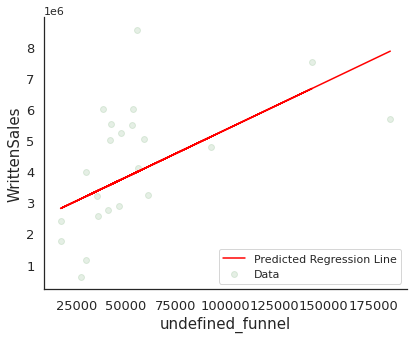

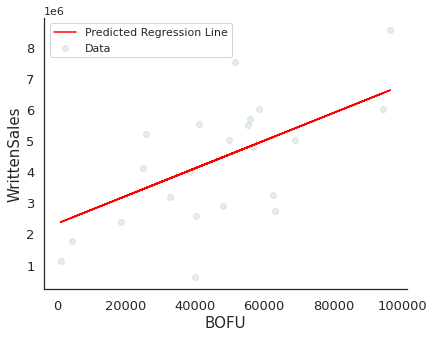

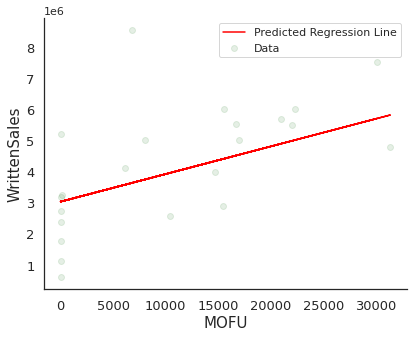

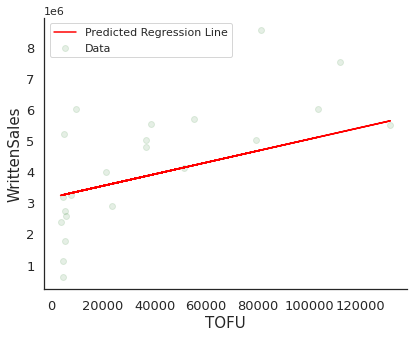

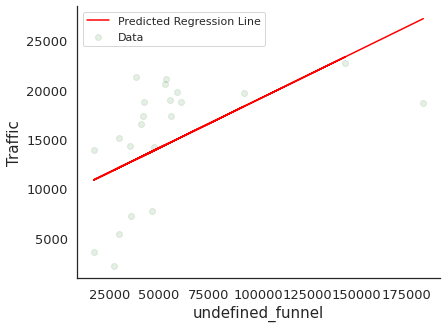

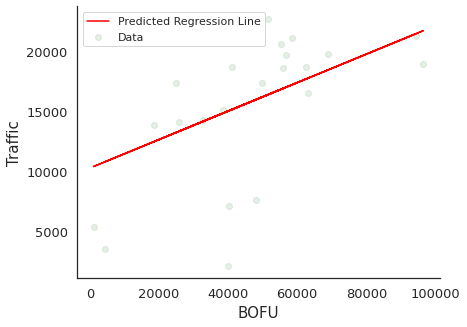

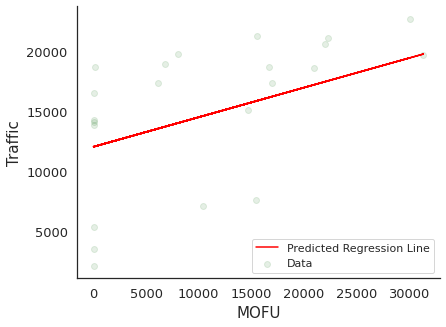

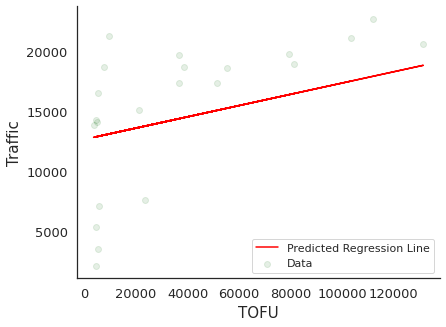

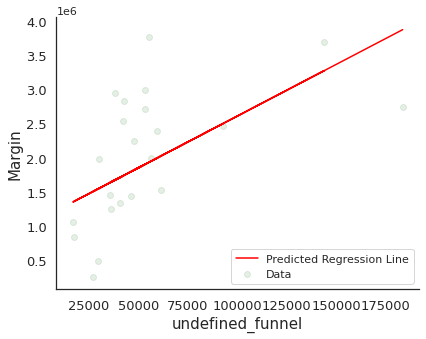

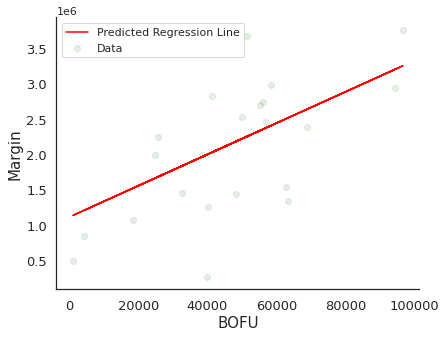

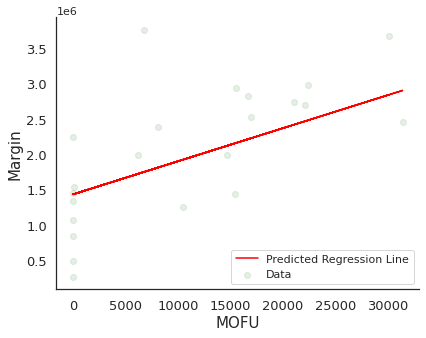

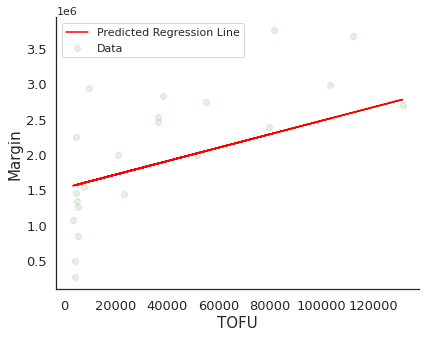

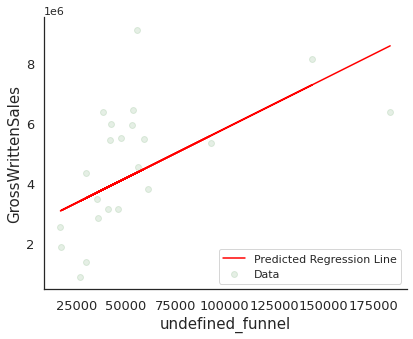

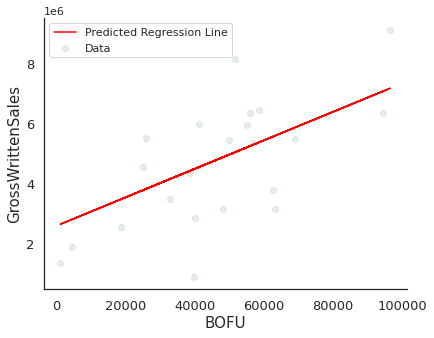

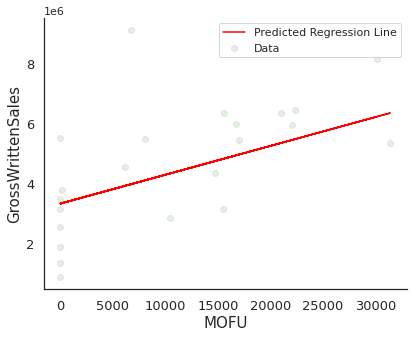

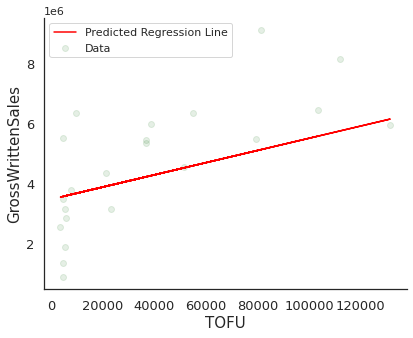

In [21]:
my_evaluation_simple_lr = pd.DataFrame({'Model': [],
                           'Independent var':[],
                           'Target var':[],             
                           'Root Mean Squared Error (RMSE)':[],
                           'R-squared (training)':[],
                           'Adjusted R-squared (training)':[],
                           'R-squared (test)':[],
                           'Adjusted R-squared (test)':[],
                           '5-Fld Cross Validation':[]})



train_data,test_data = train_test_split(my_df,train_size = 0.8,random_state=42)
# print(train_data.shape)

target = ["WrittenSales", "Traffic", "Margin", "GrossWrittenSales"]
ind = my_df.columns[:-4]

for t in target:
    for i in ind:
        
        ################### train-test #######################
        X_train = np.array(train_data[i], dtype=pd.Series).reshape(-1,1)
        y_train = np.array(train_data[t], dtype=pd.Series)
        

        X_test = np.array(test_data[i], dtype=pd.Series).reshape(-1,1)
        y_test = np.array(test_data[t], dtype=pd.Series)
        
        print(X_train.shape, y_train.shape)
        
        # specify model

        lin_reg = LinearRegression()
        lin_reg.fit(X_train, y_train)

        # predict prices of X_test
        y_pred = lin_reg.predict(X_test)

        my_rmsesm = float(format(np.sqrt(metrics.mean_squared_error(y_test,y_pred)),'.3f'))
        my_rtrsm = float(format(lin_reg.score(X_train, y_train),'.3f'))
        my_rtesm = float(format(lin_reg.score(X_test, y_test),'.3f'))
#         my_cv = float(format(cross_val_score(lin_reg,my_df[i],my_df[t],cv=5).mean(),'.3f'))
        
        print("================================================")
        print(f'Simple Linear Regression with {i} and {t}:')
        print ("Average Price for Test Data: {:.3f}".format(y_test.mean()))
        print('Intercept: {}'.format(lin_reg.intercept_))
        print('Coefficient: {}'.format(lin_reg.coef_))

        r = my_evaluation_simple_lr.shape[0]
        my_evaluation_simple_lr.loc[r] = ['Simple Linear Regression',i,t,my_rmsesm, my_rtrsm,'-',my_rtesm,'-','-']
    #     print(my_evaluation)

        sns.set(style="white", font_scale=1)

        plt.figure(figsize=(6.5,5))
        plt.scatter(X_test,y_test,color='darkgreen',label="Data", alpha=.1)
        plt.plot(X_test,lin_reg.predict(X_test),color="red",label="Predicted Regression Line")
        plt.xlabel(f"{i}", fontsize=15)
        plt.ylabel(f"{t}", fontsize=15)
        plt.xticks(fontsize=13)
        plt.yticks(fontsize=13)
        plt.legend()

        plt.gca().spines['right'].set_visible(False)
        plt.gca().spines['top'].set_visible(False)
        
my_evaluation_simple_lr

In [ ]:
my_evaluation_simple_lr.sort_values(by =["R-squared (training)"], ascending = False).head(10)

,Model,Independent var,Target var,Root Mean Squared Error (RMSE),R-squared (training),Adjusted R-squared (training),R-squared (test),Adjusted R-squared (test),5-Fld Cross Validation
12,Simple Linear Regression,undefined_funnel,GrossWrittenSales,1759376.055,0.489,-,0.276,-,-
8,Simple Linear Regression,undefined_funnel,Margin,806237.842,0.472,-,0.269,-,-
0,Simple Linear Regression,undefined_funnel,WrittenSales,1707233.085,0.469,-,0.245,-,-
10,Simple Linear Regression,MOFU,Margin,715821.867,0.442,-,0.424,-,-
14,Simple Linear Regression,MOFU,GrossWrittenSales,1676876.822,0.402,-,0.342,-,-
2,Simple Linear Regression,MOFU,WrittenSales,1610908.963,0.388,-,0.328,-,-
9,Simple Linear Regression,BOFU,Margin,725307.615,0.366,-,0.408,-,-
13,Simple Linear Regression,BOFU,GrossWrittenSales,1569281.624,0.363,-,0.424,-,-
1,Simple Linear Regression,BOFU,WrittenSales,1506644.237,0.361,-,0.412,-,-
4,Simple Linear Regression,undefined_funnel,Traffic,5333.445,0.348,-,0.204,-,-


In [ ]:
my_evaluation_simple_lr.to_csv("Marketing_Spend_Week_Funnel_Simple_LR_results.csv")

# <span id="10"></span> Multiple Regression
<hr/>

I used a <a href=#4>simple linear regression</a> and found a poor fit. In order to improve this model I am planing to add more features. When we have **more than one** feature in a linear regression, it is defined as **multiple regression**. Then, it is time to create some complex models.

## <span id="11"></span> Multiple Regression - 1

I determined ***features*** at first sight by looking at the previous sections and used in my first multiple linear regression. As in the simple regression, I printed the coefficients which the model uses for the predictions. However, this time we must use the below definition for our predictions, if we want to make calculations manually.

$$h_{\theta}(X)=\theta_{0}+\theta_{1}x_{1}+\theta_{2}x_{2}+...+\theta_{n}x_{n}$$

# Multiple Regression 

In [ ]:
my_evaluation_mul_linear = pd.DataFrame({'Model': [],
                           'Features':[],
                           'Target var':[],    
                           'Root Mean Squared Error (RMSE)':[],
                           'R-squared (training)':[],
                           'Adjusted R-squared (training)':[],         
                           'R-squared (test)':[],
                           'Adjusted R-squared (test)':[],
                           'accuracy_te_wo_tun':[],
                           'best_params' : []
                           })

target = ["WrittenSales", "Traffic", "Margin", "GrossWrittenSales"]
features = my_df.columns[:-4]


train_data,test_data = train_test_split(my_df,train_size = 0.8,random_state=42)

for t in target:    
    X = my_df[features].values
    y = my_df[t].values

    ################### train-test #######################
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state=100)
    
    from sklearn import preprocessing
    X_train = preprocessing.normalize(X_train)
    X_test = preprocessing.normalize(X_test)
    
    ################### Cross Validation and Grid Search ###################
    # step-1: create a cross-validation scheme
    folds = KFold(n_splits = 5, shuffle = True, random_state = 100)

    # step-2: specify range of hyperparameters to tune
    hyper_params = [{'n_features_to_select': list(range(1,len(my_df.columns)))}]
    
    # step-3: perform grid search
    # 3.1 specify model
    lm = LinearRegression()
    lm.fit(X_train, y_train)

    prediction = lm.predict(X_test)
    r2_wo_tuning = lm.score(X_test,y_test)
    print("Before feature selection {}  score: {} ".format(t,r2_wo_tuning))
 
    rfe = RFE(lm) 

    # 3.2 call GridSearchCV()`
    model_cv = GridSearchCV(estimator = rfe, 
                            param_grid = hyper_params, 
                            scoring= 'r2', 
                            cv = folds, 
                            verbose = 1,
                            return_train_score=True) 
    
    ################### fit the grid search model ###################
    model_cv.fit(X_train, y_train)                  

    cv_results = pd.DataFrame(model_cv.cv_results_)
    n_features_optimal = cv_results["param_n_features_to_select"][cv_results["mean_test_score"] == cv_results["mean_test_score"].max()].values
    print("the optimal number of features:", n_features_optimal)
    ################### fit the new model with the optimal number of features ###################
    lm1 = LinearRegression()

    complex_model = RFE(lm1, n_features_to_select=int(n_features_optimal[0]))             
    complex_model = complex_model.fit(X_train, y_train)

    # predict prices of X_test
    y_pred = complex_model.predict(X_test)


    complex_model = linear_model.LinearRegression()
    complex_model.fit(train_data[features],train_data[t])
    pred = complex_model.predict(test_data[features])

#     print('Intercept: {}'.format(complex_model.intercept_))
#     print('Coefficients: {}'.format(complex_model.coef_))

    rmsecm = float(format(np.sqrt(metrics.mean_squared_error(test_data[t],pred)),'.3f'))
    rtrcm = float(format(complex_model.score(train_data[features],train_data[t]),'.3f'))
    artrcm = float(format(adjustedR2(complex_model.score(train_data[features],train_data[t]),train_data.shape[0],len(features)),'.3f'))
    rtecm = float(format(complex_model.score(test_data[features],test_data[t]),'.3f'))
    artecm = float(format(adjustedR2(complex_model.score(test_data[features],test_data[t]),test_data.shape[0],len(features)),'.3f'))

    print("================================================")
    print(f'Multiple Linear Regression with {t}:')
    print ("Average Price for Test Data: {:.3f}".format(y_test.mean()))
    print('Intercept: {}'.format(complex_model.intercept_))
    print('Coefficient: {}'.format(complex_model.coef_))

    r = my_evaluation_mul_linear.shape[0]
    my_evaluation_mul_linear.loc[r] = [f'Multiple Regression',"Funnel", t, rmsecm, rtrcm ,artrcm, rtecm, artecm, r2_wo_tuning, model_cv.best_params_]

my_evaluation_mul_linear

Before feature selection WrittenSales  score: -0.13951672175954366 
Fitting 5 folds for each of 7 candidates, totalling 35 fits
the optimal number of features: [4 5 6 7]
Multiple Linear Regression with WrittenSales:
Average Price for Test Data: 4321070.427
Intercept: 1658138.4949315554
Coefficient: [19.17368316 22.45666312 15.97142959  4.51557637]
Before feature selection Traffic  score: -0.46556485301814554 
Fitting 5 folds for each of 7 candidates, totalling 35 fits
the optimal number of features: [4 5 6 7]
Multiple Linear Regression with Traffic:
Average Price for Test Data: 16529.932
Intercept: 7757.921217065667
Coefficient: [0.07870827 0.05432599 0.01816315 0.00441774]
Before feature selection Margin  score: -0.07510399106770715 
Fitting 5 folds for each of 7 candidates, totalling 35 fits
the optimal number of features: [4 5 6 7]
Multiple Linear Regression with Margin:
Average Price for Test Data: 2102389.585
Intercept: 801962.29894089
Coefficient: [ 8.64514554 10.54670246 13.6498

,Model,Features,Target var,Root Mean Squared Error (RMSE),R-squared (training),Adjusted R-squared (training),R-squared (test),Adjusted R-squared (test),accuracy_te_wo_tun,best_params
0,Multiple Regression,Funnel,WrittenSales,1297197.282,0.614,0.599,0.564,0.492,-0.139517,{'n_features_to_select': 4}
1,Multiple Regression,Funnel,Traffic,4546.978,0.389,0.366,0.421,0.325,-0.465565,{'n_features_to_select': 4}
2,Multiple Regression,Funnel,Margin,585012.072,0.634,0.621,0.615,0.551,-0.075104,{'n_features_to_select': 4}
3,Multiple Regression,Funnel,GrossWrittenSales,1317222.942,0.633,0.619,0.594,0.526,-0.115363,{'n_features_to_select': 4}


In [ ]:
my_evaluation_mul_linear.to_csv(f"Marketing_Spend_Week_Funnel_Multiple_LR_results.csv")

Most of the results are overfitted!

# <span id="15"></span> Regularization
<hr/>

**Regularization** is designed to address the problem of overfitting and undefitting. **Overfitting** means high variance and is usually caused by a complicated function that creates a lot of unnecessary curves and angles unrelated to the data. This function fits training data well but might cause poor results for the test set. On the other hand, **underfitting** means low variance and a very simple model. This might also cause poor results too. **Possible remedies** are adjusting features manually or using some model selection algoritms which brings an extra workload. Conversely, when we apply regularization, all the features are kept and the model adjusts $\theta_{j}$. This especially works when we have a lot of slightly useful features. There are two widely used regularization types (Ridge and Lasso Regressions) and in this section, I used them.


If we have very few features on a data-set and the score is poor for both training and test set then it’s a problem of under-fitting. On the other hand if we have large number of features and test score is relatively poor than the training score then it’s the problem of over-generalization or over-fitting. Ridge and Lasso regression are some of the simple techniques to reduce model complexity and prevent over-fitting which may result from simple linear regression.
 
Lasso regression not only helps in reducing over-fitting but it can help us in feature selection. 

**When to use ridge vs lasso regression:**
*  Many small/medium sized effects: use *ridge*.
*  Only a few variables with medium/large effect: use *lasso*.


## <span id="16"></span> Ridge Regression

Ridge regression is called **L2 regularization** and by adding a penalty, we obtain the below equation

$$RSS_{RIDGE} = \sum_{i=1}^{m}(h_{\theta}(x_{i})-y_{i})^{2} + \alpha \sum_{j=1}^{n}\theta^{2}_{j}$$

By changing the $\alpha$ value, we can control the amount of the regularization. When we increase $\alpha$, regularization increases and the opposite is valid too. As a result of this, I selected different $\alpha$ values and used a linear regression without regularization in order to observe the differences easily.

In [ ]:
my_evaluation_mul_lineer_Ridge = pd.DataFrame({'Model': [],
                           'Features':[],
                           'Target var':[],
                           'Root Mean Squared Error (RMSE)':[],
                           'R-squared (training)':[],
                           'Adjusted R-squared (training)':[],         
                           'R-squared (test)':[],
                           'Adjusted R-squared (test)':[],
                           'accuracy_te_wo_tun':[],
                           'best_params' : []
                           })

# target = ["Traffic"]
target = ["WrittenSales", "Traffic", "Margin", "GrossWrittenSales"]
features = my_df.columns[:-4]

train_data,test_data = train_test_split(my_df,train_size = 0.8,random_state=42)

for t in target:
   
    X = my_df[features].values
    y = my_df[t].values

    ################### train-test #######################
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state=100)
    
    ################### Cross Validation and Grid Search ###################
    # step-1: create a cross-validation scheme
    folds = KFold(n_splits = 5, shuffle = True, random_state = 100)

    # step-2: specify range of hyperparameters to tune
    hyper_params = [{'alpha': np.linspace(0, 1000, 10)}]
    
############################ Alpha = 1  ############################
    # step-3: perform grid search
    # 3.1 specify model
 
    complex_model_R = linear_model.Ridge()
    complex_model_R.fit(X_train,y_train)
    
    pred = complex_model_R.predict(X_test)
    r2_wo_tuning = complex_model_R.score(X_test,y_test)
    print("Before feature selection {}  score: {} ".format(t,r2_wo_tuning))

    # 3.2 call GridSearchCV()`
    rfe = RFE(complex_model_R) 
    model_cv = GridSearchCV( estimator = complex_model_R, 
                 param_grid = hyper_params, 
                 scoring='r2',
                 cv=folds, verbose = 1,
                 return_train_score=True,
                 n_jobs=-1)
    
    ################### fit the grid search model ###################
    model_cv.fit(X_train, y_train)  
    print(model_cv.best_params_)

    complex_model_R2 =  linear_model.Ridge(**model_cv.best_params_)
    complex_model_R2.fit(X_train, y_train)

    # predict prices of X_test
    pred = complex_model_R2.predict(X_test)
    rmsecm = float(format(np.sqrt(metrics.mean_squared_error(y_test,pred)),'.3f'))
    rtrcm = float(format(complex_model_R2.score(X_train,y_train),'.3f'))
    artrcm = float(format(adjustedR2(complex_model_R2.score(X_train,y_train),X_train.shape[0],len(features)),'.3f'))
    rtecm = float(format(complex_model_R2.score(X_test,y_test),'.3f'))
    artecm = float(format(adjustedR2(complex_model_R2.score(X_test,y_test),X_test.shape[0],len(features)),'.3f'))

    print("================================================")
    print(f'Ridge Regression (alpha:1) with all features and {t}:')
    print ("Average Price for Test Data: {:.3f}".format(y_test.mean()))
  

    r = my_evaluation_mul_lineer_Ridge.shape[0]
    my_evaluation_mul_lineer_Ridge.loc[r] = ['Ridge Regression',"Funnel", t, rmsecm, rtrcm ,artrcm, rtecm, artecm, r2_wo_tuning, model_cv.best_params_]

my_evaluation_mul_lineer_Ridge

Before feature selection WrittenSales  score: 0.6422101703680476 
Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'alpha': 1000.0}
Ridge Regression (alpha:1) with all features and WrittenSales:
Average Price for Test Data: 4321070.427
Before feature selection Traffic  score: 0.13350303656086926 
Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'alpha': 1000.0}
Ridge Regression (alpha:1) with all features and Traffic:
Average Price for Test Data: 16529.932
Before feature selection Margin  score: 0.6651214097704714 
Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'alpha': 1000.0}
Ridge Regression (alpha:1) with all features and Margin:
Average Price for Test Data: 2102389.585
Before feature selection GrossWrittenSales  score: 0.6740208817274089 
Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'alpha': 1000.0}
Ridge Regression (alpha:1) with all features and GrossWrittenSales:
Average Price for Test Data: 4705482.479


,Model,Features,Target var,Root Mean Squared Error (RMSE),R-squared (training),Adjusted R-squared (training),R-squared (test),Adjusted R-squared (test),accuracy_te_wo_tun,best_params
0,Ridge Regression,Funnel,WrittenSales,865817.193,0.596,0.581,0.642,0.583,0.642210,{'alpha': 1000.0}
1,Ridge Regression,Funnel,Traffic,4899.850,0.430,0.409,0.134,-0.011,0.133503,{'alpha': 1000.0}
2,Ridge Regression,Funnel,Margin,415523.722,0.625,0.611,0.665,0.609,0.665121,{'alpha': 1000.0}
3,Ridge Regression,Funnel,GrossWrittenSales,872198.878,0.617,0.603,0.674,0.620,0.674021,{'alpha': 1000.0}


In [ ]:
my_evaluation_mul_lineer_Ridge.sort_values(by = "R-squared (training)", ascending = False)

,Model,Features,Target var,Root Mean Squared Error (RMSE),R-squared (training),Adjusted R-squared (training),R-squared (test),Adjusted R-squared (test),accuracy_te_wo_tun,best_params
2,Ridge Regression,Funnel,Margin,415523.722,0.625,0.611,0.665,0.609,0.665121,{'alpha': 1000.0}
3,Ridge Regression,Funnel,GrossWrittenSales,872198.878,0.617,0.603,0.674,0.620,0.674021,{'alpha': 1000.0}
0,Ridge Regression,Funnel,WrittenSales,865817.193,0.596,0.581,0.642,0.583,0.642210,{'alpha': 1000.0}
1,Ridge Regression,Funnel,Traffic,4899.850,0.430,0.409,0.134,-0.011,0.133503,{'alpha': 1000.0}


In [ ]:
my_evaluation_mul_lineer_Ridge.to_csv("Marketing_Spend_Week_Funnel_MLR_RIDGE_results.csv")

## <span id="17"></span> Lasso Regression

Lasso regression is called **L1 regularization** and it is defined as

$$RSS_{LASSO} = \sum_{i=1}^{m}(h_{\theta}(x_{i})-y_{i})^{2} + \alpha \sum_{j=1}^{n}|\theta_{j}|$$

The main difference between ridge and lasso is the penalty but $\alpha$ works the same way.   

In [ ]:
my_evaluation_mul_lineer_Lasso =  pd.DataFrame({'Model': [],
                           'Features':[],
                           'Target var':[],  
                           'Root Mean Squared Error (RMSE)':[],
                           'R-squared (training)':[],
                           'Adjusted R-squared (training)':[],         
                           'R-squared (test)':[],
                           'Adjusted R-squared (test)':[],
                           'accuracy_te_wo_tun':[],
                           'best_params' : []
                           })
# =
# target = ["Traffic"]
target = ["WrittenSales", "Traffic", "Margin", "GrossWrittenSales"]
features = my_df.columns[:-4]

train_data,test_data = train_test_split(my_df,train_size = 0.8,random_state=42)

for t in target:
   
    X = my_df[features].values
    y = my_df[t].values

    ################### train-test #######################
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state=100)
    
    ################### Cross Validation and Grid Search ###################
    # step-1: create a cross-validation scheme
    folds = KFold(n_splits = 5, shuffle = True, random_state = 100)

    # step-2: specify range of hyperparameters to tune
    hyper_params = [{'alpha': np.linspace(0, 100, 10)}]
    
############################ Alpha = 1  ############################
    # step-3: perform grid search
    # 3.1 specify model
 
    complex_model_L = linear_model.Lasso()
    complex_model_L.fit(X_train,y_train)
    
    pred = complex_model_L.predict(X_test)
    r2_wo_tuning = complex_model_L.score(X_test,y_test)
    print("Before feature selection {}  score: {} ".format(t,r2_wo_tuning))

    # 3.2 call GridSearchCV()`
    rfe = RFE(complex_model_L) 
    model_cv = GridSearchCV( estimator = complex_model_L, 
                 param_grid = hyper_params, 
                 scoring='r2',
                 cv=folds, verbose = 1,
                 return_train_score=True,
                 n_jobs=-1)
    
    ################### fit the grid search model ###################
    model_cv.fit(X_train, y_train)  
    print(model_cv.best_params_)

    complex_model_L2 =  linear_model.Lasso(**model_cv.best_params_)
    complex_model_L2.fit(X_train, y_train)

    # predict prices of X_test
    pred = complex_model_L2.predict(X_test)
    rmsecm = float(format(np.sqrt(metrics.mean_squared_error(y_test,pred)),'.3f'))
    rtrcm = float(format(complex_model_L2.score(X_train,y_train),'.3f'))
    artrcm = float(format(adjustedR2(complex_model_L2.score(X_train,y_train),X_train.shape[0],len(features)),'.3f'))
    rtecm = float(format(complex_model_L2.score(X_test,y_test),'.3f'))
    artecm = float(format(adjustedR2(complex_model_L2.score(X_test,y_test),X_test.shape[0],len(features)),'.3f'))

    print("================================================")
    print(f'Lasso Regression (alpha:1) with all features and {t}:')
    print ("Average Price for Test Data: {:.3f}".format(y_test.mean()))
  

    r = my_evaluation_mul_lineer_Lasso.shape[0]
    my_evaluation_mul_lineer_Lasso.loc[r] = ['Lasso Regression',"Funnel", t, rmsecm, rtrcm ,artrcm, rtecm, artecm, r2_wo_tuning, model_cv.best_params_]

my_evaluation_mul_lineer_Lasso

Before feature selection WrittenSales  score: 0.6422101703648913 
Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'alpha': 0.0}
Lasso Regression (alpha:1) with all features and WrittenSales:
Average Price for Test Data: 4321070.427
Before feature selection Traffic  score: 0.1335030469776778 
Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'alpha': 0.0}
Lasso Regression (alpha:1) with all features and Traffic:
Average Price for Test Data: 16529.932
Before feature selection Margin  score: 0.6651214097529909 
Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'alpha': 0.0}
Lasso Regression (alpha:1) with all features and Margin:
Average Price for Test Data: 2102389.585
Before feature selection GrossWrittenSales  score: 0.6740208817260946 
Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'alpha': 0.0}
Lasso Regression (alpha:1) with all features and GrossWrittenSales:
Average Price for Test Data: 4705482.479


,Model,Features,Target var,Root Mean Squared Error (RMSE),R-squared (training),Adjusted R-squared (training),R-squared (test),Adjusted R-squared (test),accuracy_te_wo_tun,best_params
0,Lasso Regression,Funnel,WrittenSales,865817.185,0.596,0.581,0.642,0.583,0.642210,{'alpha': 0.0}
1,Lasso Regression,Funnel,Traffic,4899.850,0.430,0.409,0.134,-0.011,0.133503,{'alpha': 0.0}
2,Lasso Regression,Funnel,Margin,415523.718,0.625,0.611,0.665,0.609,0.665121,{'alpha': 0.0}
3,Lasso Regression,Funnel,GrossWrittenSales,872198.870,0.617,0.603,0.674,0.620,0.674021,{'alpha': 0.0}


In [ ]:
my_evaluation_mul_lineer_Lasso.sort_values(by = "R-squared (training)", ascending = False)

,Model,Features,Target var,Root Mean Squared Error (RMSE),R-squared (training),Adjusted R-squared (training),R-squared (test),Adjusted R-squared (test),accuracy_te_wo_tun,best_params
2,Lasso Regression,Funnel,Margin,415523.718,0.625,0.611,0.665,0.609,0.665121,{'alpha': 0.0}
3,Lasso Regression,Funnel,GrossWrittenSales,872198.870,0.617,0.603,0.674,0.620,0.674021,{'alpha': 0.0}
0,Lasso Regression,Funnel,WrittenSales,865817.185,0.596,0.581,0.642,0.583,0.642210,{'alpha': 0.0}
1,Lasso Regression,Funnel,Traffic,4899.850,0.430,0.409,0.134,-0.011,0.133503,{'alpha': 0.0}


In [ ]:
my_evaluation_mul_lineer_Lasso.to_csv("Marketing_Spend_Week_Funnel_MLR_LASSO_results.csv")

# <span id="19"></span> k-NN Regression 
<hr/>

I included k-NN regression in this kernel but actually, I did not expect to obtain a good result by using it. Also, k-NN does not give much insight. It is a very simple method and the idea behind the algorithm is similar to the k-NN classification. Briefly, it uses the weighted average, median or another statistic you want of k-nearest instances.

The evaluation metrics for the training, test sets and different *k* values were given in the below table. It can be seen that, k-NN was not very successful as expected. 

In [ ]:
my_evaluation_knn = pd.DataFrame({'Model': [],
                           'Features':[],
                           'Target var':[],       
                           'Root Mean Squared Error (RMSE)':[],
                           'R-squared (training)':[],
                           'Adjusted R-squared (training)':[],         
                           'R-squared (test)':[],
                           'Adjusted R-squared (test)':[],
                           'accuracy_te_wo_tun':[],
                           'best_params' : []
                           })

target = ["WrittenSales", "Traffic", "Margin", "GrossWrittenSales"]
features = my_df.columns[:-4]


train_data,test_data = train_test_split(my_df,train_size = 0.8,random_state=42)

for t in target:
   
    X = my_df[features].values
    y = my_df[t].values

    ################### train-test #######################
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state=100)
    
    ################### Cross Validation and Grid Search ###################
    # step-1: create a cross-validation scheme
    folds = KFold(n_splits = 5, shuffle = True, random_state = 100)

    # step-2: specify range of hyperparameters to tune
    hyper_params = [{'n_neighbors': list(range(1,len(my_df.columns))), 'weights': ['uniform','distance']}]
 

    ######################## MODEL #######################
    
    # step-3: perform grid search
    # 3.1 specify model
    knnreg = KNeighborsRegressor() 
    knnreg.fit(X_train,y_train)
    
    pred = knnreg.predict(X_test)
    r2_wo_tuning = knnreg.score(X_test,y_test)
    print("Before feature selection {}  score: {} ".format(t,r2_wo_tuning))

    # 3.2 call GridSearchCV()`
    model_cv = GridSearchCV(estimator = knnreg, 
                            param_grid = hyper_params, 
                            scoring= 'r2', 
                            cv = folds, 
                            verbose = 1,
                            return_train_score=True) 
    
    ################### fit the grid search model ###################
    model_cv.fit(X_train, y_train)
    
    cv_results = pd.DataFrame(model_cv.cv_results_)

    print(model_cv.best_params_["n_neighbors"])
#     print(cv_results)
    ################### fit the new model with the optimal number of features ###################
    knnreg2 = KNeighborsRegressor(**model_cv.best_params_)   
    knnreg2.fit(X_train, y_train)
    
    # Get the results
    print(model_cv.best_score_)
#     print(model_cv.best_estimator_)
#     print(model_cv.best_params_)

    # predict prices of X_test
    pred = knnreg2.predict(X_test)
    

    rmsecm = float(format(np.sqrt(metrics.mean_squared_error(y_test,pred)),'.3f'))
    rtrcm = float(format(knnreg2.score(X_train,y_train),'.3f'))
    artrcm = float(format(adjustedR2(knnreg2.score(X_train,y_train),train_data.shape[0],len(features)),'.3f'))
    rtecm = float(format(knnreg2.score(X_test,y_test),'.3f'))
    artecm = float(format(adjustedR2(knnreg2.score(X_test,y_test),test_data.shape[0],len(features)),'.3f'))

    r = my_evaluation_knn.shape[0]
    my_evaluation_knn.loc[r+(model_cv.best_params_["n_neighbors"])-1] = ['KNN Regression',"Funnel", t, rmsecm, rtrcm ,artrcm, rtecm, artecm, r2_wo_tuning, model_cv.best_params_]
    r = r+len(features)
my_evaluation_knn

Before feature selection WrittenSales  score: 0.41909142989915826 
Fitting 5 folds for each of 14 candidates, totalling 70 fits
7
0.48240721954827925
Before feature selection Traffic  score: 0.23560557084151923 
Fitting 5 folds for each of 14 candidates, totalling 70 fits
2
0.19430718816229137
Before feature selection Margin  score: 0.4177217517949625 
Fitting 5 folds for each of 14 candidates, totalling 70 fits
3
0.5090228674259467
Before feature selection GrossWrittenSales  score: 0.4580309492865101 
Fitting 5 folds for each of 14 candidates, totalling 70 fits
7
0.5066362325349578


,Model,Features,Target var,Root Mean Squared Error (RMSE),R-squared (training),Adjusted R-squared (training),R-squared (test),Adjusted R-squared (test),accuracy_te_wo_tun,best_params
6,KNN Regression,Funnel,WrittenSales,1085495.728,1.0,1.0,0.438,0.344,0.419091,"{'n_neighbors': 7, 'weights': 'distance'}"
2,KNN Regression,Funnel,Traffic,4451.076,1.0,1.0,0.285,0.166,0.235606,"{'n_neighbors': 2, 'weights': 'distance'}"
4,KNN Regression,Funnel,Margin,579462.709,1.0,1.0,0.349,0.240,0.417722,"{'n_neighbors': 3, 'weights': 'distance'}"
9,KNN Regression,Funnel,GrossWrittenSales,1093536.022,1.0,1.0,0.488,0.402,0.458031,"{'n_neighbors': 7, 'weights': 'distance'}"


In [ ]:
my_evaluation_knn.sort_values(by = 'R-squared (training)', ascending = False )

,Model,Features,Target var,Root Mean Squared Error (RMSE),R-squared (training),Adjusted R-squared (training),R-squared (test),Adjusted R-squared (test),accuracy_te_wo_tun,best_params
6,KNN Regression,Funnel,WrittenSales,1085495.728,1.0,1.0,0.438,0.344,0.419091,"{'n_neighbors': 7, 'weights': 'distance'}"
2,KNN Regression,Funnel,Traffic,4451.076,1.0,1.0,0.285,0.166,0.235606,"{'n_neighbors': 2, 'weights': 'distance'}"
4,KNN Regression,Funnel,Margin,579462.709,1.0,1.0,0.349,0.240,0.417722,"{'n_neighbors': 3, 'weights': 'distance'}"
9,KNN Regression,Funnel,GrossWrittenSales,1093536.022,1.0,1.0,0.488,0.402,0.458031,"{'n_neighbors': 7, 'weights': 'distance'}"


In [ ]:
my_evaluation_knn.to_csv("Marketing_Spend_Week_Funnel_KNN_regression_results.csv")

# Gradient Boosting Regressor

In [ ]:
from sklearn import ensemble

In [ ]:
my_evaluation_GB =  pd.DataFrame({'Model': [],
                           'Features':[],
                           'Target var':[],
                           'Root Mean Squared Error (RMSE)':[],
                           'R-squared (training)':[],
                           'Adjusted R-squared (training)':[],         
                           'R-squared (test)':[],
                           'Adjusted R-squared (test)':[],
                           'accuracy_te_wo_tun':[],
                           'best_params' : []
                           })

# target = ["Traffic"]
target = ["WrittenSales", "Traffic", "Margin", "GrossWrittenSales"]
features = my_df.columns[:-4]

for t in target:
    X = my_df[features].values
    y = my_df[t].values

    ################### train-test #######################
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state=100)
    
    ################### Cross Validation and Grid Search ###################
    # step-1: create a cross-validation scheme
    folds = KFold(n_splits = 5, shuffle = True, random_state = 100)

    # step-2: specify range of hyperparameters to tune
    hyper_params = [{'n_estimators':[5,50,250,500,1000,2000],
                     'learning_rate':[.001,0.01,.1,10,100],
                     'max_depth':[1,2,4],
                     'subsample':[.5,.75,1,3,5,7,9],
                     'random_state':[10]
                     }]

 
 ######################## MODEL #######################
    from sklearn import ensemble
    GBR = ensemble.GradientBoostingRegressor()
    GBR.fit(X_train, y_train) 
    pred = GBR.predict(X_test)
    r2_wo_tuning = GBR.score(X_test,y_test)
    print("==============================================================================")
    print("Before feature selection score: {} for {} ".format(r2_wo_tuning, t))

    
    from sklearn.model_selection import GridSearchCV
    model_cv = GridSearchCV(estimator=GBR, 
                        param_grid = hyper_params, 
                        scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True,
                        n_jobs=-1)
    # fit the model
    model_cv.fit(X_train, y_train)                  

    cv_results = pd.DataFrame(model_cv.cv_results_)
    
    GBR2 = ensemble.GradientBoostingRegressor(**model_cv.best_params_)          
    GBR2.fit(X_train, y_train)
    
    print("=====================Grid Search Results=========================================================")    
    #Get the results
    print(f"Best Score: {model_cv.best_score_}")
    print(f"Best Estimator: {model_cv.best_estimator_}")
    print(f"Best Parameters: {model_cv.best_params_}")

    pred = GBR2.predict(X_test)
    


    rmsecm = float(format(np.sqrt(metrics.mean_squared_error(y_test,pred)),'.3f'))
    rtrcm = float(format(GBR2.score(X_train,y_train),'.3f'))
    artrcm = float(format(adjustedR2(GBR2.score(X_train,y_train),X_train.shape[0],len(features)),'.3f'))
    rtecm = float(format(GBR2.score(X_test,y_test),'.3f'))
    artecm = float(format(adjustedR2(GBR2.score(X_test,y_test),X_test.shape[0],len(features)),'.3f'))



#     print(f'Gradient Boosting with all features and {t}:')
    print ("Average Price for Test Data: {:.3f}".format(y_test.mean()))
    print("================================================")
    
    r = my_evaluation_GB.shape[0]
    # my_evaluation_GB.loc[r] = ['Gradient Boosting',"Funnel", t, rmsecm, rtrcm ,artrcm, rtecm, artecm, r2_wo_tuning, model_cv.best_params_]
    my_evaluation_GB.loc[r] = ['Gradient Boosting',"Funnel", t, rmsecm, rtrcm ,artrcm, rtecm, artecm, r2_wo_tuning, "default"]

my_evaluation_GB

Before feature selection score: 0.5788067942925245 for WrittenSales 
Fitting 5 folds for each of 630 candidates, totalling 3150 fits
=====================Grid Search Results=========================================================
Best Score: 0.5299792254218039
Best Estimator: GradientBoostingRegressor(learning_rate=0.001, max_depth=2, n_estimators=2000,
                          random_state=10, subsample=0.5)
Best Parameters: {'learning_rate': 0.001, 'max_depth': 2, 'n_estimators': 2000, 'random_state': 10, 'subsample': 0.5}
Average Price for Test Data: 4321070.427
Before feature selection score: 0.5102477435972779 for Traffic 
Fitting 5 folds for each of 630 candidates, totalling 3150 fits
=====================Grid Search Results=========================================================
Best Score: 0.2837364671404822
Best Estimator: GradientBoostingRegressor(learning_rate=0.01, max_depth=1, n_estimators=250,
                          random_state=10, subsample=1)
Best Parameters: {'l

,Model,Features,Target var,Root Mean Squared Error (RMSE),R-squared (training),Adjusted R-squared (training),R-squared (test),Adjusted R-squared (test),accuracy_te_wo_tun,best_params
0,Gradient Boosting,Funnel,WrittenSales,884874.115,0.759,0.749,0.626,0.564,0.578807,default
1,Gradient Boosting,Funnel,Traffic,4349.561,0.631,0.617,0.317,0.203,0.510248,default
2,Gradient Boosting,Funnel,Margin,451213.223,0.800,0.793,0.605,0.539,0.648676,default
3,Gradient Boosting,Funnel,GrossWrittenSales,912876.544,0.773,0.765,0.643,0.583,0.552283,default


In [ ]:
my_evaluation_GB

,Model,Features,Target var,Root Mean Squared Error (RMSE),R-squared (training),Adjusted R-squared (training),R-squared (test),Adjusted R-squared (test),accuracy_te_wo_tun,best_params
0,Gradient Boosting,Funnel,WrittenSales,884874.115,0.759,0.749,0.626,0.564,0.578807,default
1,Gradient Boosting,Funnel,Traffic,4349.561,0.631,0.617,0.317,0.203,0.510248,default
2,Gradient Boosting,Funnel,Margin,451213.223,0.800,0.793,0.605,0.539,0.648676,default
3,Gradient Boosting,Funnel,GrossWrittenSales,912876.544,0.773,0.765,0.643,0.583,0.552283,default


In [ ]:
my_evaluation_GB.to_csv("Marketing_Spend_Week_Funnel_GB_regression_results.csv")

# Decision Tree Regressor

In [ ]:
from sklearn.tree import DecisionTreeRegressor

In [ ]:
my_evaluation_DT = pd.DataFrame({'Model': [],
                           'Features':[],
                           'Target var':[],      
                           'Root Mean Squared Error (RMSE)':[],
                           'R-squared (training)':[],
                           'Adjusted R-squared (training)':[],         
                           'R-squared (test)':[],
                           'Adjusted R-squared (test)':[],
                           'accuracy_te_wo_tun':[],
                           'best_params' : []
                           })

target = ["WrittenSales", "Traffic", "Margin", "GrossWrittenSales"]
features = my_df.columns[:-4]

for t in target:
   
    X = my_df[features].values
    y = my_df[t].values

    ################### train-test #######################
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state=100)
    
    ################### Cross Validation and Grid Search ###################
    # step-1: create a cross-validation scheme
    from sklearn.model_selection import KFold
    folds = KFold(n_splits = 5, shuffle = True, random_state = 100)

    # step-2: specify range of hyperparameters to tune
    hyper_params = [{"splitter":["best","random"],
            "max_depth" : [1,3,5,7,9,11,12],
           "min_samples_leaf":[1,2,3,4,5,6,7,8,9,10],
           "min_weight_fraction_leaf":[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
           "max_features":["auto","log2","sqrt",None],
           "max_leaf_nodes":[None,10,20,30,40,50,60,70,80,90] }]
 
 
 ######################## MODEL #######################
    dtreg = DecisionTreeRegressor(random_state = 100)
    dtreg.fit(X_train, y_train)
    pred = dtreg.predict(X_test)
    r2_wo_tuning = dtreg.score(X_test,y_test)
    print("Before feature selection {}  score: {} ".format(t,r2_wo_tuning))



    from sklearn.model_selection import GridSearchCV
    model_cv = GridSearchCV(estimator=dtreg, 
                        param_grid = hyper_params, 
                        scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True,
                        n_jobs=-1)
    # fit the model
    model_cv.fit(X_train, y_train)                  

    cv_results = pd.DataFrame(model_cv.cv_results_)

    # Get the results
    print(f"Best Score: {model_cv.best_score_}")
    print(f"Best Estimator: {model_cv.best_estimator_}")
    print(f"Best Parameters: {model_cv.best_params_}")

    dtreg2 =  DecisionTreeRegressor(**model_cv.best_params_)
    dtreg2.fit(X_train, y_train)
    pred = dtreg2.predict(X_test)
    
    
    rmsecm = float(format(np.sqrt(metrics.mean_squared_error(y_test,pred)),'.3f'))
    rtrcm = float(format(dtreg2.score(X_train,y_train),'.3f'))
    artrcm = float(format(adjustedR2(dtreg2.score(X_train,y_train),X_train.shape[0],len(features)),'.3f'))
    rtecm = float(format(dtreg2.score(X_test,y_test),'.3f'))
    artecm = float(format(adjustedR2(dtreg2.score(X_test,y_test),X_test.shape[0],len(features)),'.3f'))

    print("================================================")
#     print(f' Decision Tree with all features and {t}:')
#     print ("Average Price for Test Data: {:.3f}".format(y_test.mean()))
    
    r = my_evaluation_DT.shape[0]
    my_evaluation_DT.loc[r] = ['Decision Tree',"Funnel", t, rmsecm, rtrcm ,artrcm, rtecm, artecm, r2_wo_tuning, model_cv.best_params_]

my_evaluation_DT

Before feature selection WrittenSales  score: -0.07149287542493754 
Fitting 5 folds for each of 50400 candidates, totalling 252000 fits
Best Score: 0.5395296004653349
Best Estimator: DecisionTreeRegressor(max_depth=5, max_features='log2', max_leaf_nodes=10,
                      min_weight_fraction_leaf=0.1, random_state=100)
Best Parameters: {'max_depth': 5, 'max_features': 'log2', 'max_leaf_nodes': 10, 'min_samples_leaf': 1, 'min_weight_fraction_leaf': 0.1, 'splitter': 'best'}
Before feature selection Traffic  score: 0.04212877378112945 
Fitting 5 folds for each of 50400 candidates, totalling 252000 fits
Best Score: 0.24039391182794825
Best Estimator: DecisionTreeRegressor(max_depth=5, max_features='log2', min_samples_leaf=9,
                      min_weight_fraction_leaf=0.1, random_state=100)
Best Parameters: {'max_depth': 5, 'max_features': 'log2', 'max_leaf_nodes': None, 'min_samples_leaf': 9, 'min_weight_fraction_leaf': 0.1, 'splitter': 'best'}
Before feature selection Margin  s

,Model,Features,Target var,Root Mean Squared Error (RMSE),R-squared (training),Adjusted R-squared (training),R-squared (test),Adjusted R-squared (test),accuracy_te_wo_tun,best_params
0,Decision Tree,Funnel,WrittenSales,922476.134,0.660,0.648,0.594,0.526,-0.071493,"{'max_depth': 5, 'max_features': 'log2', 'max_..."
1,Decision Tree,Funnel,Traffic,4579.824,0.612,0.597,0.243,0.117,0.042129,"{'max_depth': 5, 'max_features': 'log2', 'max_..."
2,Decision Tree,Funnel,Margin,363696.757,0.677,0.665,0.743,0.701,0.358929,"{'max_depth': 3, 'max_features': 'log2', 'max_..."
3,Decision Tree,Funnel,GrossWrittenSales,1062430.423,0.652,0.639,0.516,0.436,0.292393,"{'max_depth': 5, 'max_features': 'log2', 'max_..."


In [ ]:
my_evaluation_DT.to_csv("Marketing_Spend_Week_Funnel_DT_regression_results.csv")

In [ ]:
frames = [my_evaluation_mul_lineer_Ridge, my_evaluation_mul_lineer_Lasso, my_evaluation_mul_linear, my_evaluation_knn, my_evaluation_GB, my_evaluation_DT]
all_results = pd.concat(frames)
all_results.to_csv("Marketing_Spend_Funnel_Classification_results_ALL.csv")

# Random Forest Regressor

In [22]:
my_evaluation_RF = pd.DataFrame({'Model': [],
                           'Features':[],
                           'Target var':[],     
                           'Root Mean Squared Error (RMSE)':[],
                           'R-squared (training)':[],
                           'Adjusted R-squared (training)':[],         
                           'R-squared (test)':[],
                           'Adjusted R-squared (test)':[],
                           'accuracy_te_wo_tun':[],
                           'best_params' : []
                           })

target = ["WrittenSales", "Traffic", "Margin", "GrossWrittenSales"]
features = my_df.columns[:-4]

for t in target:
   
    X = my_df[features].values
    y = my_df[t].values

    ################### train-test #######################
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state=100)
    
    ################### Cross Validation and Grid Search ###################
    # step-1: create a cross-validation scheme
    from sklearn.model_selection import KFold
    folds = KFold(n_splits = 5, shuffle = True, random_state = 100)

    # step-2: specify range of hyperparameters to tune
    hyper_params = [{
        'bootstrap': [True],
        'max_depth': [80, 90, 100, 110],
        'max_features': [2, 3],
        'min_samples_leaf': [3, 4, 5],
        'min_samples_split': [8, 10, 12],
        'n_estimators': [100, 200, 300, 1000]}]
 
 
 ######################## MODEL #######################  
    from sklearn.ensemble import RandomForestRegressor
    rand_for = RandomForestRegressor(n_estimators = 3, random_state = 42)
    rand_for.fit(X_train, y_train)
    pred = rand_for.predict(X_test)
    r2_wo_tuning = rand_for.score(X_test,y_test)
    print("==============================================================================")
    print("Before feature selection score: {} for {} ".format(r2_wo_tuning, t))


    from sklearn.model_selection import GridSearchCV
    model_cv = GridSearchCV(estimator = rand_for, 
                            param_grid = hyper_params, 
                            scoring= 'r2', 
                            cv = folds, 
                            verbose = 1,
                            return_train_score=True)
        
    # fit the model
    model_cv.fit(X_train, y_train)                  

    cv_results = pd.DataFrame(model_cv.cv_results_)
    
    print("================Grid Search Results===================================")
    # Get the results
    print(f"Best Score: {model_cv.best_score_}")
    print(f"Best Estimator: {model_cv.best_estimator_}")
    print(f"Best Parameters: {model_cv.best_params_}")
    print("===================================================")
        
    ################### fit the new model with the optimal number of features ###################
    rand_for2 = RandomForestRegressor(**model_cv.best_params_)   
    rand_for2.fit(X_train, y_train)

    # predict prices of X_test
    pred = rand_for2.predict(X_test)
    
    rmsecm = float(format(np.sqrt(metrics.mean_squared_error(y_test,pred)),'.3f'))
    rtrcm = float(format(rand_for2.score(X_train,y_train),'.3f'))
    artrcm = float(format(adjustedR2(rand_for2.score(X_train,y_train),X_train.shape[0],len(features)),'.3f'))
    rtecm = float(format(rand_for2.score(X_test,y_test),'.3f'))
    artecm = float(format(adjustedR2(rand_for2.score(X_test,y_test),X_test.shape[0],len(features)),'.3f'))

    print(f"=====================Random Forest with all features and {t}:===========================")
    print ("Average Price for Test Data: {:.3f}".format(y_test.mean()))
    
    r = my_evaluation_RF.shape[0]
    my_evaluation_RF.loc[r] = ['Random Forest',"Funnel", t, rmsecm, rtrcm ,artrcm, rtecm, artecm, r2_wo_tuning, model_cv.best_params_]

my_evaluation_RF

Before feature selection score: 0.45749614717078657 for WrittenSales 
Fitting 5 folds for each of 288 candidates, totalling 1440 fits
================Grid Search Results===================================
Best Score: 0.589131122875578
Best Estimator: RandomForestRegressor(max_depth=80, max_features=2, min_samples_leaf=3,
                      min_samples_split=10, n_estimators=200, random_state=42)
Best Parameters: {'bootstrap': True, 'max_depth': 80, 'max_features': 2, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 200}
=====================Random Forest with all features and WrittenSales:===========================
Average Price for Test Data: 4321070.427
Before feature selection score: 0.22564141914510538 for Traffic 
Fitting 5 folds for each of 288 candidates, totalling 1440 fits
================Grid Search Results===================================
Best Score: 0.2897079214922547
Best Estimator: RandomForestRegressor(max_depth=80, max_features=2, min_samples_leaf=3

,Model,Features,Target var,Root Mean Squared Error (RMSE),R-squared (training),Adjusted R-squared (training),R-squared (test),Adjusted R-squared (test),accuracy_te_wo_tun,best_params
0,Random Forest,Funnel,WrittenSales,877774.734,0.782,0.774,0.632,0.571,0.457496,"{'bootstrap': True, 'max_depth': 80, 'max_feat..."
1,Random Forest,Funnel,Traffic,4105.237,0.776,0.767,0.392,0.290,0.225641,"{'bootstrap': True, 'max_depth': 80, 'max_feat..."
2,Random Forest,Funnel,Margin,410605.989,0.808,0.800,0.673,0.619,0.490466,"{'bootstrap': True, 'max_depth': 80, 'max_feat..."
3,Random Forest,Funnel,GrossWrittenSales,932782.090,0.757,0.748,0.627,0.565,0.428467,"{'bootstrap': True, 'max_depth': 80, 'max_feat..."


In [23]:
my_evaluation_RF.to_csv("Marketing_Spend_Week_Funnel_RF_regression_results.csv")

In [ ]:
frames = [my_evaluation_mul_lineer_Ridge, my_evaluation_mul_lineer_Lasso, my_evaluation_mul_linear, my_evaluation_knn, my_evaluation_GB, my_evaluation_DT, my_evaluation_RF]
all_results = pd.concat(frames)
all_results.to_csv("Marketing_Spend_Funnel_Regression_results_ALL.csv")